In [160]:
import numpy as np
import random
import models
from collections import Counter


In [138]:
def obs_map(tokens, vocab_list):
    """HMM can only handle integer sequences, so we
    map every word to an integer"""
    mapped_tokens = []
    for token in tokens:
        mapped_tokens.append(vocab_list.index(token))
    return mapped_tokens


In [139]:
f = open("data/shakespeare.txt", "r")
text = f.read()
poems = text.split("\n\n")
shakesphere_poems = []
for i, poem in enumerate(poems):
    poem = poem.replace(",", " , ")
    poem = poem.replace(":", " : ")
    poem = poem.replace("?", " ? ")
    poem = poem.replace(";", " ; ")
    poem = poem.replace(";", " ; ")
    poem = poem.replace("!", " ! ")
    poem = poem.replace("\n", " \n ")
    poem = poem.replace(".", " . ")
    poem = poem.replace("(", "")
    poem = poem.replace(")", "")
    lines = poem.split("\n")
    if i == 0:
        lines = lines[1:]
    else:
        lines = lines[2:]
    shakesphere_poems.append([])
    for line in lines:
        tokens = line.split(" ")
        tokens = [x.lower() for x in tokens if (x != "" and not x.isdigit())]
        tokens.insert(0, "<START>")
        tokens.append("<STOP>")
        shakesphere_poems[-1].append(tokens)


In [140]:
f = open("data/spenser.txt", "r")
text = f.read()
poems = text.split("\n\n")
spenser_poems = []
for i, poem in enumerate(poems):
    if i % 2 == 0:
        continue
    poem = poem.replace(",", " , ")
    poem = poem.replace(":", " : ")
    poem = poem.replace("?", " ? ")
    poem = poem.replace(";", " ; ")
    poem = poem.replace(";", " ; ")
    poem = poem.replace("!", " ! ")
    poem = poem.replace("\n", " \n ")
    poem = poem.replace(".", " . ")
    poem = poem.replace("(", "")
    poem = poem.replace(")", "")
    lines = poem.split("\n")
    spenser_poems.append([])
    for line in lines:
        tokens = line.split(" ")
        tokens = [x.lower() for x in tokens if (x != "" and not x.isdigit())]
        tokens.insert(0, "<START>")
        tokens.append("<STOP>")
        spenser_poems[-1].append(tokens)


In [141]:
all_poems = []
all_poems.extend(shakesphere_poems)
# all_poems.extend(spenser_poems)

all_poems_backwards = (
    []
)  # All poems but starts each line with last word of line and reads backwards
for poem in all_poems:
    all_poems_backwards.append([])
    for line in poem:
        line = line[1:-1]
        if len(line[-1]) == 1:
            line = line[:-1]
        all_poems_backwards[-1].append(line[::-1])


In [142]:
mega_list = []
for poem in all_poems_backwards:
    for line in poem:
        mega_list.extend(line)
vocab_counts = Counter(mega_list)
vocab_list = sorted(vocab_counts.items(), key=lambda x: x[1])
vocab_list = [x for (x, y) in vocab_list]
vocab_list.reverse()

tokenized_poems = []
for i in range(len(all_poems_backwards)):
    for j in range(len(all_poems_backwards[i])):
        tokenized_poems.append(obs_map(all_poems_backwards[i][j], vocab_list))


In [222]:
patterns = [[0, 2], [1, 3], [4, 6], [5, 7], [8, 10], [9, 11], [12, 13]]

rhyme_dict_temp = []

for poem in all_poems_backwards:
    if len(poem) != 14:
        continue
    for pattern in patterns:
        word_1 = poem[pattern[0]][0]
        word_2 = poem[pattern[1]][0]
        in_dict = False
        for rhymes in rhyme_dict_temp:
            if word_1 in rhymes or word_2 in rhymes:
                rhymes.add(word_1)
                rhymes.add(word_2)
                in_dict = True
                break
        if not in_dict:
            rhyme_dict_temp.append(set([word_1, word_2]))


In [226]:
rhyme_dict = []
for i in range(len(rhyme_dict_temp)):
    for j in range(i+1, len(rhyme_dict_temp)):
        if rhyme_dict_temp[i] & rhyme_dict_temp[j]:
            rhyme_dict_temp[i] = rhyme_dict_temp[i].union(rhyme_dict_temp[j])
            rhyme_dict_temp[j].clear()

for i in range(len(rhyme_dict_temp)):
    if rhyme_dict_temp[i]:
        rhyme_dict.append(rhyme_dict_temp[i])


In [144]:
model = models.unsupervised_HMM(tokenized_poems, 16, 20)


Unsupervised Learning Begins
Iteration 20  - And Input 2154

In [153]:
modified_vocab_list = []
for vocab in vocab_list:
    if vocab[-1] == "'":
        vocab = vocab[:-1]
    modified_vocab_list.append(vocab)

f = open("data/Syllable_dictionary.txt", "r")
text = f.read()
lines = text.split("\n")
word_to_syllables = dict()
syllables_to_word = dict()
for line in lines:
    words = line.split(" ")
    if words[0] not in modified_vocab_list:
        continue
    word = modified_vocab_list.index(words[0])
    count = words[-1]
    if "E" in count:
        count = words[-2]
    word_to_syllables[word] = int(count)

    if word_to_syllables[word] in syllables_to_word.keys():
        syllables_to_word[word_to_syllables[word]].append(word)
    else:
        syllables_to_word[word_to_syllables[word]] = [word]


In [201]:
def reverse_obs_map(tokens, vocab_list):
    """For unmapping words back to real tokens"""
    unmapped_tokens = []
    for token in tokens:
        unmapped_tokens.append(vocab_list[token])
    return unmapped_tokens


def sample_line(hmm, vocab_list, end_word, end_punctuation="", max_words=10):
    start_token = obs_map([end_word], vocab_list)[0]
    emission, states = hmm.generate_emission(max_words, start_token)
    sentence = emission[::-1]
    sentence.append(start_token)

    syllables = [
        word_to_syllables[word] if (word in word_to_syllables.keys()) else 0
        for word in sentence
    ]
    sums = [sum(syllables[i:]) for i in range(len(syllables))]
    for i in range(len(sums)):
        if sums[i] == sums[i + 1]:
            i += 1
        if sums[i] == 10:
            sentence = sentence[i:]
            break
        if sums[i] < 10:
            sentence = sentence[i:]
            sentence.insert(0, random.choice(syllables_to_word[10 - sums[i]]))
            break

    sentence = reverse_obs_map(sentence, vocab_list)
    output = " ".join(sentence).capitalize()
    output = output.replace(" i ", " I ")
    output = output.replace(" .", ".")
    output = output.replace(" ?", "?")
    output = output.replace(" ,", ",")
    output = output.replace(" :", ":")
    output = output.replace(" ;", ";")
    output = output.replace(" !", "!")
    output = output + end_punctuation
    return output


In [227]:
for _ in range(20):
    sample_poem = [[] for _ in range(14)]

    for i, pattern in enumerate(patterns):
        j = random.choice(range(len(rhyme_dict)))
        end_word1 = random.choice([x for x in rhyme_dict[j]])
        end_word2 = random.choice([x for x in rhyme_dict[j] if (x != end_word1)])

        end_punc1 = random.choice(["", ",", ":", "."])
        end_punc2 = random.choice(["", ",", ":", "."])
        if pattern[1] == 13:
            end_punc2 = "."

        sample_poem[pattern[0]] = sample_line(
            model, vocab_list, end_word1, end_punc1
        )
        sample_poem[pattern[1]] = sample_line(
            model, vocab_list, end_word2, end_punc2
        )

    print("\n".join(sample_poem))
    print()


That land that couplement in of measure:
Some thoughts for on a being that subscribes
And and misprision when days, the leisure,
Stars then thou can love for thou brass, one tribes,
Force alive unbless believe much hide style:
Given unthrift which for seem a think sea:
Lo upon is I love think fight compile
Most now bring, may gift for in sick my plea:
True that my tattered oaths on injuries:
Still razed mine for all hath they survey
Banks the diest to another enemies:
All than of subject this grieved careful sway.
Truth to red died be be looked the not ward:
Heart by thou particulars the here's guard.

What though that a tattered thereby their, sheds,
Fall her hope truth out act a face staineth.
Hear'st chronicle as their true untrue breeds
What's loving with, true filled things disdaineth,
Which reasons good thy men thee the befits:
And catch self not and tongue any will pace
Shall see that that, lov'st marble is commits.
Heavy in receive poor that level race.
Which beauty holds music

Reading Data Shakespeare
 Poem 153
 Finished loading

 Making Vocabulary
Unsupervised Learning Begins
Iteration 20  - And Input 153

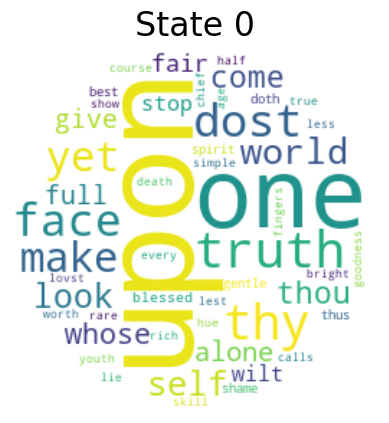

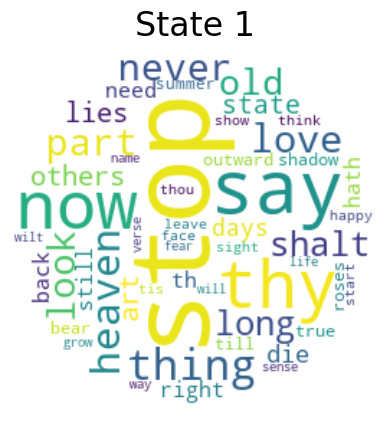

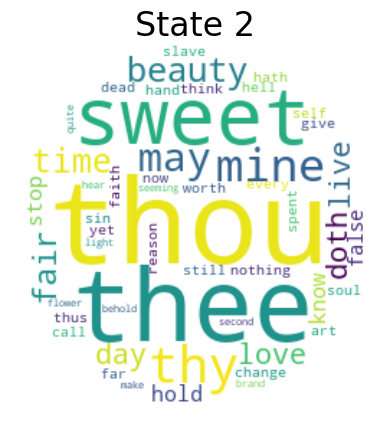

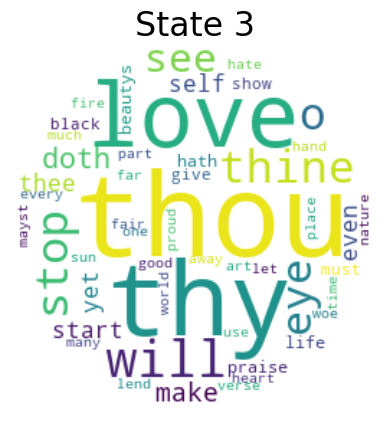

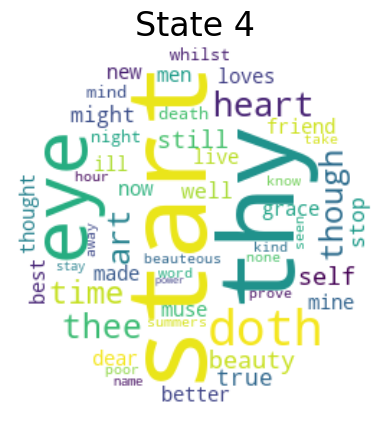

Sentence 0



Ah absent queen are other i best seem strange, even in thou shorn now?
to and. 
, writ full the muse,
will night of ill life's is false my with
more a might deceive doth
youngly these beauty, steel to me thy alack to i not the pleased, fade,
so my detain before him they thee and
let, unbred roof or minion doubt glutton
Sentence 1




 of
Sentence 2



;
to which thou blenches the heart,
to thee hast heart. torment love, entertain that into!
perjured
can thee most
what within who faults was in no put thou to
the waste 
. evil descriptions i the minds
thy level,
heavily then you with leave,
feeds his a their thoughts, of do be o'er elsewhere, thee shall 
,
Sentence 3



Of
for is thy brand to actor, shine o the face when distillation,
all thee are merit, 
: ghost hard painter, soil me friends their thy character, posterity my my strong, see climbed bearer, with so after bad am and it loss summers' strength's. 
, do seasons to i some is wrecked, him my greater own grace were

In [ ]:
#THIS IS WHAT YOU RUN TO GET YOUR POEMS:
import re
from models import HiddenMarkovModel as HMM
import models
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from collections import Counter
import random
# from embeding_utils import make_embed_model  , convert_text
# from gensim.models import word2vec
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

def load_and_tokenize_shakespeare():
    '''This Loads data from the shakespeare.txt file.
    It should return a list where each element is a poem.
    That poem should be tokenized (ie it is a list where
    each element is a token. Each poem starts with
    the <START> token and ends with the <STOP> token.)'''
    print("Reading Data Shakespeare")
    f = open('data/shakespeare.txt','r')
    text = f.read()
    text = text.lower()
    poems = text.split('\n\n')
    token_list = []
    for i , poem in enumerate(poems):
        print(f"\r Poem {i}", end='')
        poem = poem.replace(',', ' , ')
        poem = poem.replace(':', ' : ')
        poem = poem.replace('?', ' ? ')
        poem = poem.replace(';', ' ; ')
        poem = poem.replace(';', ' ; ')
        poem = poem.replace('!', ' ! ')
        poem = poem.replace('\n', ' \n ')
        poem = poem.replace('.',' . ')
        poem = poem.replace('(','')
        poem = poem.replace(')','')
        tokens = poem.split(' ')
        tokens.insert(0,'<START>')
        tokens.append('<STOP>')
        tokens = [x for x in tokens if (x != '' and not x.isdigit())]
        token_list.append(tokens)

    print("\n Finished loading")
    print("\n Making Vocabulary")
    mega_list = []
    for tokens in token_list:
        mega_list.extend(tokens)
    vocab_counts = Counter(mega_list)
    vocab_list = sorted(vocab_counts.items(), key=lambda x: x[1])
    vocab_list = [x for (x,y) in vocab_list]
    vocab_list.reverse()
    #Returns a list of tokens
    # and also a vocabulary sorted by the frequency of the tokens
    return token_list , vocab_list

def load_and_tokenize_spencer():
    '''This Loads data from the shakespeare.txt file.
    It should return a list where each element is a poem.
    That poem should be tokenized (ie it is a list where
    each element is a token. Each poem starts with
    the <START> token and ends with the <STOP> token.)'''
    print("Reading Data Spencer")
    f = open('data/spenser.txt','r')
    text = f.read()
    text = text.lower()
    poems = text.split('\n\n')
    token_list = []
    for i , poem in enumerate(poems):
        print(f"\r Poem {i}", end='')
        poem = poem.replace(',', ' , ')
        poem = poem.replace(':', ' : ')
        poem = poem.replace('?', ' ? ')
        poem = poem.replace(';', ' ; ')
        poem = poem.replace(';', ' ; ')
        poem = poem.replace('!', ' ! ')
        poem = poem.replace('\n', ' \n ')
        poem = poem.replace('.',' . ')
        poem = poem.replace('(','')
        poem = poem.replace(')','')
        tokens = poem.split(' ')
        tokens.insert(0,'<START>')
        tokens.append('<STOP>')
        tokens = [x for x in tokens if (x != '' and x != '\t')]
        token_list.append(tokens)

    print("\n Finished loading")
    print("\n Making Vocabulary")
    mega_list = []
    for tokens in token_list:
        mega_list.extend(tokens)
    vocab_counts = Counter(mega_list)
    vocab_list = sorted(vocab_counts.items(), key=lambda x: x[1])
    vocab_list = [x for (x,y) in vocab_list]
    vocab_list.reverse()
    #Returns a list of tokens
    # and also a vocabulary sorted by the frequency of the tokens
    return token_list , vocab_list


def load_and_tokenize_collated():
    '''This Loads data from the shakespeare.txt file.
    It should return a list where each element is a poem.
    That poem should be tokenized (ie it is a list where
    each element is a token. Each poem starts with
    the <START> token and ends with the <STOP> token.)'''
    print("Reading Data Spencer")
    f = open('data/collated_sonnets.txt','r')
    text = f.read()
    text = text.lower()
    poems = text.split('\n\n')
    token_list = []
    for i , poem in enumerate(poems):
        print(f"\r Poem {i}", end='')
        poem = poem.replace(',', ' , ')
        poem = poem.replace(':', ' : ')
        poem = poem.replace('?', ' ? ')
        poem = poem.replace(';', ' ; ')
        poem = poem.replace(';', ' ; ')
        poem = poem.replace('!', ' ! ')
        poem = poem.replace('\n', ' \n ')
        poem = poem.replace('--', ' , ')
        poem = poem.replace('.',' . ')
        poem = poem.replace('(','')
        poem = poem.replace(')','')
        tokens = poem.split(' ')
        tokens.insert(0,'<START>')
        tokens.append('<STOP>')
        tokens = [x for x in tokens if (x != '' and x != '\t')]
        token_list.append(tokens)

    print("\n Finished loading")
    print("\n Making Vocabulary")
    mega_list = []
    for tokens in token_list:
        mega_list.extend(tokens)
    vocab_counts = Counter(mega_list)
    vocab_list = sorted(vocab_counts.items(), key=lambda x: x[1])
    vocab_list = [x for (x,y) in vocab_list]
    vocab_list.reverse()
    #Returns a list of tokens
    # and also a vocabulary sorted by the frequency of the tokens
    return token_list , vocab_list



def obs_map(tokens, vocab_list):
    '''HMM can only handle integer sequences, so we
    map every word to an integer'''
    mapped_tokens = []
    for token in tokens:
        mapped_tokens.append(vocab_list.index(token))
    return mapped_tokens

def reverse_obs_map(tokens,vocab_list):
    '''For unmapping words back to real tokens'''
    unmapped_tokens = []
    for token in tokens:
        unmapped_tokens.append(vocab_list[token])
    return unmapped_tokens

class ObsMapEmbed:
    #This class is for use in the LSTM.
    def __init__(self,vocab):
        self.vocab = vocab

    def embed(self,tokens):
        #Takes a list of words and embeds them.
        return th.nn.functional.one_hot(th.tensor(obs_map(tokens,self.vocab)),num_classes = len(self.vocab))

    def unembed(self,tokens):
        # recieves a list of one hot embedded tokens and then turns them into words.

        return reverse_obs_map(tokens,self.vocab)

def sample_sentence(hmm, vocab_list, max_words=1000):
    # Get reverse map.

    # Sample and convert sentence.
    end_token = obs_map(['<STOP>'],vocab_list)[0]
    start_token = obs_map(['<START>'],vocab_list)[0]
    emission, states = hmm.generate_emission(max_words,start_token,end_token=end_token)
    sentence = emission
    sentence = reverse_obs_map(sentence,vocab_list)
    output = ' '.join(sentence).capitalize()
    output = output.replace(' <start>','')
    output = output.replace(' .','.')
    output = output.replace(' ?','?')
    output = output.replace(' ,',',')
    output = output.replace(' :',':')
    output = output.replace(' ;',';')
    output = output.replace(' !','!')
    output = output.replace(' \n ','\n')
    print(output)
    #TODO figure out how to output the sates as well,
    #So that they also end at <STOP>
    return output


def load_and_tokenize_spenser():
    '''This Loads data from the spenser.txt file.
    It should return a list where each element is a poem.
    That poem should be tokenized (ie it is a list where
    each element is a token. Each poem starts with
    the <START> token and ends with the <STOP> token.'''
    pass
    #TODO PROBABLY BASED ON SHAKESPEARE VERSION

def train_HMM(tokens, model):
    '''train an HMM on a set of tokens
    Where the tokens are of the form outputed by load_and_tokenize'''
    #TODO: RN the HMM can only handle numbers
    #TODO JUST USE THEIR CODE.
    pass


def LSTM_loss(y,y_hat):
    return th.mean(-th.log(th.cosine_similarity(y,y_hat)))

def train_LSTM(model,X,batch_size,num_epochs,lr):
    '''

    :param model: an LSTM model
    :param X: a list of sequences
    :param batch_size:
    :param num_epochs:
    :return:
    '''
    Y = [model.embedding_model.embed(x[1:]) for x in X]
    X = [model.embedding_model.embed(x[:-1]) for x in X]
    train_dataset = data_utils.TensorDataset(th.nn.utils.rnn.pad_sequence(X).permute([1,0,2]).float(), th.nn.utils.rnn.pad_sequence(Y).permute([1,0,2]).float())
    data = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr)
    loss_fun = nn.CrossEntropyLoss(reduction='mean')
    for epoch in range(num_epochs):
        avg_loss = 0
        counter = 0
        for x, y in data:
            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_fun(th.flatten(y_hat,0,1), th.flatten(y,0,1))
            loss.backward()
            optimizer.step()
            avg_loss += loss
            counter += 1
        print(f"epoch - {epoch} avg_loss: {avg_loss / counter}")
        model.sample_sentence(max_tokens=15)
    print("Finished")
    return model

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()
        # save the image
        wordcloud.to_file(f"wordcloud_{title}.png")

    return wordcloud
def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []

        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1

            # Add the encoded word.
            obs_elem.append(obs_map[word])

        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i )[0]]
        # remove any numbers above 2000
        obs_lst = obs_lst[obs_lst < 2000]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


def experiment():
    '''Makes the Model, Trains the Model, Outputs some poem
    examples, then outputs some visualizations.'''
    #Load the tokens from Shakespeare
    token_list , vocab_list = load_and_tokenize_shakespeare()
    #Then map them s.t. each word is an integer
    mapped_token_list = []
    mega_list = []
    for tokens in token_list:
        mapped_token_list.append(obs_map(tokens, vocab_list))
        mega_list.extend(obs_map(tokens, vocab_list))
    model = models.unsupervised_HMM(mapped_token_list,5,20)
    text = text_to_wordcloud(" ".join(vocab_list), show=False)
    obs, obs_mape = parse_observations(" ".join(vocab_list))
    states_to_wordclouds(model, obs_mape)
    for i in range(40):
        print(f"Sentence {i}\n\n\n")
        sample_sentence(model,vocab_list,300)
    print("END OF PROGRAM")

def lstm_experiment():
    token_list, vocab_list = load_and_tokenize_collated()
    embed = ObsMapEmbed(vocab_list)
    model = models.LSTM_Poet(400,embed,len(vocab_list))
    model = train_LSTM(model, token_list, 16, 30,.01)
    print("\n\n\n\n final sample poems:")
    for i in range(40):
        print(f"\n\nPoem {i}\n" )
        model.sample_sentence(500)

if __name__ == '__main__':
    experiment()
    lstm_experiment()